In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import numpy as np
import os
import cv2
from skimage import data, io, filters
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml # Fetch_openml được sử dụng để lấy tập dữ liệu từ kho dữ liệu của OpenML
import sklearn
import time

In [20]:
rnd = np.random
rnd.seed(97)


In [21]:
_lambda = 10**-4

In [22]:
def cal_f(A,b, _lambda, x):
    f = 1/2*np.linalg.norm(np.matmul(A,x)-b,2)**2
    return f

def cal_phi(_lambda, x):
    phi = _lambda*np.linalg.norm(x,1)
    return phi

def cal_F(A, b, _lambda, x):
    f = cal_f(A,b, _lambda, x)
    phi = cal_phi(_lambda, x)

    return f + phi

In [23]:
def cal_L(A):
    eigen_values,_ = np.linalg.eig(np.matmul(A.T,A))
    L = max(eigen_values)
    return L

In [24]:
def grad_f(A, b, x):
    result = np.matmul(A.T, (np.matmul(A, x) - b))
    return result

In [25]:
def cal_p(alpha, _lambda, x_i):
    if x_i > alpha*_lambda:

        return x_i - alpha*_lambda
    elif np.abs(x_i) <= alpha*_lambda:
        return 0
    elif x_i < -alpha*_lambda:
        return x_i + alpha*_lambda

In [26]:
def prox_phi(alpha, x):
    prox = np.zeros_like(x)
    for i in range(x.shape[0]):
        prox[i][0] = cal_p(alpha, _lambda, x[i][0])

    return prox

In [27]:
def GAPGA1(A, b, max_iter = 500, modified = True):
    y = []
    x = []
    z =[]
    F = []
    k = 0

    epsilon = 10**-6
    L = cal_L(A)
    kappa = 1/(L+4)
    C = 4*1/kappa

    z_0 = rnd.randint(0,1,(n,1))
    z.append(z_0)
    y_0 = z_0.copy()
    y.append(y_0)
    while True:#TODO
#         print('k = ',k)
        if modified == True:
            kappa = 1/(L + k)
        inner_x = y[k] - kappa*grad_f(A,b,y[k])
        x_k = prox_phi(kappa, inner_x)
        x.append(x_k)

        tau_k = 4/(k+5)
        y_kplus1 = tau_k*z[k] + (1-tau_k)*x_k
        y.append(y_kplus1)


        if modified == True:
            kappa_for_z = 1 / (L + k)
            C = C= 4 * 1 / kappa

        kappa_for_z = (k + 1) / C
        inner_z = z[k] - kappa_for_z * grad_f(A, b, y_kplus1)
        z_kplus1 = prox_phi(kappa_for_z, inner_z)
        z.append(z_kplus1)

        F_k = cal_F(A, b ,_lambda, x_k)
        F.append(F_k)
        if k>0:
#             diff = np.abs(F[k] - F[k-1])


# #             diff = 1
#             if diff < epsilon*F[k-1] or k == max_iter:
#                 break

            if np.linalg.norm(x[k] - x[k-1]) < epsilon* (1 + np.linalg.norm(x[k])) or k == max_iter:
#                 GAFGA_info['k'] = k
#                 return GAFGA_info
                break


        k = k + 1

    GAPGA_info = {
        'k':k,
        'x':x,
        'y':y,
        'z':z,
        'F':F
    }
    return GAPGA_info

In [28]:
def GAPGA2(A, b, max_iter = 500, modified = False):
    y = []
    x = []
    z =[]
    v= []
    F = []
    k = 0

    epsilon = 10**-6
    L = cal_L(A)
    kappa = 1/(L+4)
    C = 4*1/kappa

    z_0 = rnd.randint(0,1,(n,1))
    z.append(z_0)
    y_0 = z_0.copy()
    y.append(y_0)
    v_0 = 0
    v.append(v_0)

    while True:#TODO
#         print('k = ',k)
        if modified == True:
            kappa = 1/(L + k)
        inner_x = y[k] - kappa*grad_f(A,b,y[k])
        x_k = prox_phi(kappa, inner_x)
        x.append(x_k)

        tau_k = 4/(k+5)
        y_kplus1 = tau_k*z[k] + (1-tau_k)*x_k
        y.append(y_kplus1)

        v_kplus1 = v[k] + k*grad_f(A,b,y[k+1])
        v.append(v_kplus1)


        if modified == True:
            kappa_for_z = 1 / (L + k)
            C = C= 4 * 1 / kappa

        kappa_for_z = k*(k + 1) / (2 * C)
        inner_z = z[k] - v_kplus1
        z_kplus1 = prox_phi(kappa_for_z, inner_z)
        z.append(z_kplus1)

        F_k = cal_F(A, b ,_lambda, x_k)
        F.append(F_k)
        if k>0:
#             diff = np.abs(F[k] - F[k-1])
# #             diff = 1
#             if diff < epsilon*F[k-1] or k == max_iter:
#                 break

            if np.linalg.norm(x[k] - x[k-1]) < epsilon* (1 + np.linalg.norm(x[k])) or k == max_iter:
#                 GAFGA_info['k'] = k
#                 return GAFGA_info
                break
        k = k + 1

    GAPGA_info = {
        'k':k,
        'x':x,
        'y':y,
        'z':z,
        'v':v,
        'F':F

    }
    return GAPGA_info

In [29]:
def GAFBA(A, b, c1 = 0.25, c2 = 0.25, max_iter = 500):
    y = []
    x = []
    z =[]
    F = []
    alpha = []
    k = 0
    GAFBA_info = {
        'k':k,
        'x':x,
        'y':y,
        'z':z,
        'alpha':alpha,
        'F':F
    }

    epsilon = 10**-6
    L = cal_L(A)
    kappa = 0.9 * 1/L
#     c1 = 0.3
#     c2 = 0.3
    y_0 = np.zeros((n,1))
    x_0 = np.zeros((n,1))
    alpha_0 = 0.5
    y.append(y_0)
    x.append(x_0)
    alpha.append(alpha_0)
    k = 0
    while True:#TODO
#         print('k = ',k)
        # 1.Parameters update:
        beta_k = (c1*alpha[k] +c2*alpha[k])/2
        #alpha_kplus1 = 1/4*(1+ np.sqrt(1 + 4*(alpha[k]**2 - beta_k)))

        alpha_kplus1 = 1/2*(1+ np.sqrt(1 + 4*(alpha[k]**2 - beta_k)))
        alpha.append(alpha_kplus1)
        # 2. Find
        inner_x = y[k] - kappa*grad_f(A,b,y[k])
        x_kplus1 = prox_phi(kappa, inner_x)
        x.append(x_kplus1)

        y_kplus1 = x_kplus1 + (alpha[k] -1)/(alpha_kplus1)*(x[k+1] - x[k])
        y.append(y_kplus1)

        F_k = cal_F(A, b ,_lambda, x[k])
        F.append(F_k)
        if k>0:
        # 1
            if np.linalg.norm(x[k] - x[k-1]) < epsilon* (1 + np.linalg.norm(x[k])) or k == max_iter:
                GAFBA_info['k'] = k
                return GAFBA_info
                break

        #2
#             diff = np.abs(F[k] - F[k-1])
#             if diff < epsilon*abs(F[k-1]) or k == max_iter:
#                 GAFBA_info['k'] = k
#                 return GAFBA_info
#                 break
        k = k + 1

In [30]:
def ISTA(A,b, max_iter = 1000):

    epsilon = 10**-6
    _lambda = 10**-4

    x = []
    F = []
    t = []
    k = 0
    y = b

    ISTA_info = {
        'k':k,
        'F':F,
        'x':x,
    }

    L = cal_L(A)
    x_0 = np.zeros((n,1))
    x.append(x_0)
    k = 0
    F_0 = cal_F(A, b ,_lambda, x_0)
    F.append(F_0)
    while True:
        k = k + 1

        #t_k = 1/(k+L)
        t_k = 1/L

        t.append(t_k)
        inner_x_k = x[k-1] + t_k*np.matmul(A.T, y - np.matmul(A, x[k-1]))
        x_k = prox_phi(_lambda*t_k, inner_x_k)
        x.append(x_k)
        F_k = cal_F(A, b ,_lambda, x_k)
        F.append(F_k)

        # Converge conditon

         # 1
#         if np.linalg.norm(x[k] - x[k-1]) < epsilon* (1 + np.linalg.norm(x[k])) or k == max_iter:
#             ISTA_info['k'] = k
#             break
        # 2
        if k > 1:
            diff = np.abs(F[k] - F[k-1])
            if diff < epsilon*abs(F[k-1]) or k == max_iter:
                ISTA_info['k'] = k
                break

    return ISTA_info

In [31]:
def FISTA(A,b, max_iter = 1000):

    epsilon = 10**-6
    _lambda = 10**-4
    x = []
    F = []
    t = []
    k = 0
    y = b

    ISTA_info = {
        'k':k,
        'F':F,
        'x':x,
    }

    L = cal_L(A)
    x_0 = np.zeros((n,1))
    x.append(x_0)
    k = 0
    F_0 = cal_F(A, b ,_lambda, x_0)
    F.append(F_0)
    while True:
        k = k + 1

        t_k = 1/(k + L)
        t.append(t_k)

        if k > 1:
            v = x[k-1] + (k-2)/(k+1)*(x[k-1] - x[k-2])
            inner_x_k = v + t_k*np.matmul(A.T, y - np.matmul(A, x[k-1]))
            x_k = prox_phi(_lambda*t_k, inner_x_k)
            x.append(x_k)
        else:
            inner_x_k = x[k-1] + t_k*np.matmul(A.T, y - np.matmul(A, x[k-1]))
            x_k = prox_phi(_lambda*t_k, inner_x_k)
            x.append(x_k)

        F_k = cal_F(A, b ,_lambda, x_k)
        F.append(F_k)

        # converge conditon
        if np.linalg.norm(x[k] - x[k-1]) < epsilon* (1 + np.linalg.norm(x[k])) or k == max_iter:
            ISTA_info['k'] = k
            break

    return ISTA_info

## Numerical Experiments
#---------------------------------

## => Bài toán Khử mờ hình ảnh
 ## -------------------------------------------
 ## Làm mờ hình ảnh bằng the blur operator: A = RW (R is blurring matrix and W contains a wavelet basis)
  ## -------------------------------------------


In [32]:
_lambda = 10**-6
max_iter = 500
epsilon = 10**-3

Làm mờ hình ảnh bằng cv2.filter2D




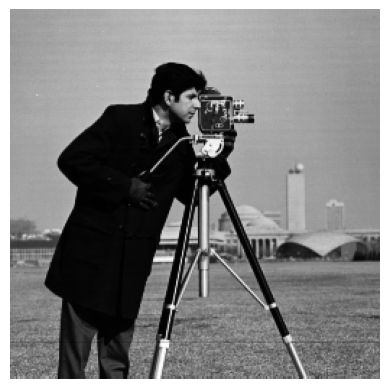

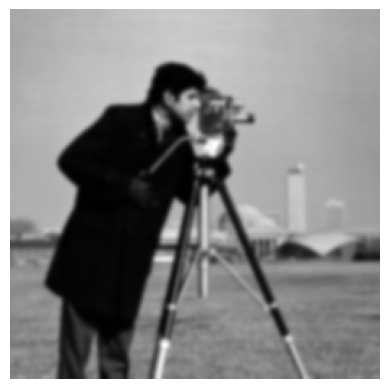

In [ ]:
# import matplotlib.pyplot as plt

# # Đọc hình ảnh từ file
# image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image/cameraman.pgm')
# # image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image/tire.tif', cv2.IMREAD_GRAYSCALE)
# # image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image/z4770817220766_bd0a723d1d145f80a121ff9de1f6d69f.jpg')



# # Kiểm tra xem hình ảnh có được đọc thành công không
# if image is None:
#     print("Không thể đọc hình ảnh.")
# else:
#     # Chuyển đổi hình ảnh sang ảnh grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # gray_image = image

#     # Định nghĩa kích thước và sigma cho kernel Gaussian
#     kernel_size = 15 #47560 # ???
#     sigma = 1.5 #sigma quyết định độ rộng của hàm phân phối Gaussian, và nó ảnh hưởng đến mức độ làm mờ của ảnh.

#     # Tạo kernel Gaussian
#     gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)

#     # Tạo ma trận làm mờ
#     R = np.outer(gaussian_kernel, gaussian_kernel.transpose())

#     # Thử chọn W là 1 ma trận đơn vị // -> chưa làm được cái wavelet
#     # W = np.eye(R.shape[0])
#     W = np.eye(kernel_size)

#     # Xây dựng the blurring matrix: A = RW
#     A = np.matmul(R, W)

#     # Làm mờ hình ảnh bằng cách sử dụng phép toán convolution
#     blurred_image = cv2.filter2D(gray_image, -1, A)
#     cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/image/cam_blured.jpg', blurred_image)
#     # cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/image/tire_blured.jpg', blurred_image)
#     # cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/image/Trang_blured.jpg', blurred_image)

#     # Hiển thị hình ảnh gốc
#     plt.imshow(gray_image, cmap='gray')
#     plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
#     plt.show()

#     # Hiển thị hình ảnh đã làm mờ
#     plt.imshow(blurred_image, cmap='gray')
#     plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
#     plt.show()


In [33]:
!pip install pylops

In [34]:
import pylops
import cv2

In [38]:

# im = np.load("../testdata/python.npy")[::5, ::5, 0]


# im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image/cameraman.pgm', cv2.IMREAD_GRAYSCALE)
# im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image/tire.tif', cv2.IMREAD_GRAYSCALE)
im = cv2.imread('/content/drive/MyDrive/Colab Notebooks/imresizer-1704771863386.jpg', cv2.IMREAD_GRAYSCALE)
# im = np.array(im, dtype = np.float64) / 255

hang, cot = im.shape

m = hang*cot
n = hang*cot

print(type(im))
print(hang, cot)
print(hang*cot)
print(im)

<class 'numpy.ndarray'>
50 50
2500
[[ 0  5  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 ...
 [ 0 13  0 ...  8  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Random 1 ảnh bất kỳ

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Kích thước của ảnh
# # image_size = (100, 100)
# image_size = (50, 50)

# # Tạo một ma trận ảnh ngẫu nhiên trong khoảng [0, 255]
# im = np.random.randint(0, 256, size=image_size, dtype=np.uint8)
# hang, cot = im.shape

# m = hang*cot
# n = hang*cot

# print(type(im))
# print(hang, cot)
# print(hang*cot)
# print(im)

# # # Hiển thị ảnh
# # plt.imshow(random_image, cmap='gray', vmin=0, vmax=255)
# # plt.axis('off')  # Tắt trục
# # plt.show()


<class 'numpy.ndarray'>
50 50
2500
[[ 27  58 126 ...  56 135 168]
 [ 46  67 113 ... 187  53 194]
 [217  83 194 ...  36 184 231]
 ...
 [ 15  70 146 ...  90  74 115]
 [ 87  85 241 ... 253  43  69]
 [210  65 193 ...  30 112 154]]


<class 'pylops.signalprocessing.convolve2d.Convolve2D'>
(2500, 2500)


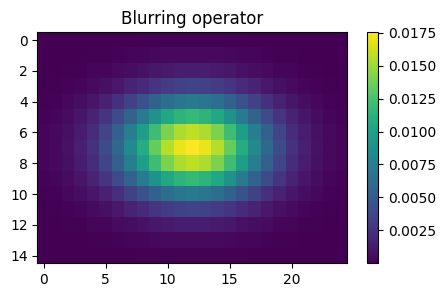

In [39]:
hang, cot = im.shape

# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.03 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")

# blurring operator
Cop = pylops.signalprocessing.Convolve2D(
    (hang, cot), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)
print(type(Cop))
print(Cop.shape)

Làm mờ hình ảnh bằng toán tử convolution: Cop

<class 'numpy.ndarray'>
(50, 50)


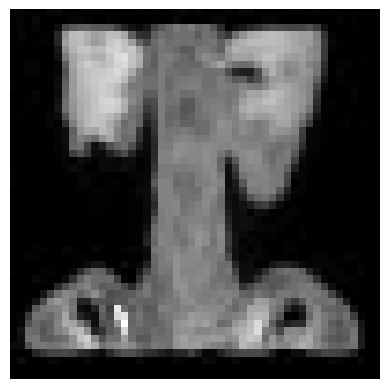

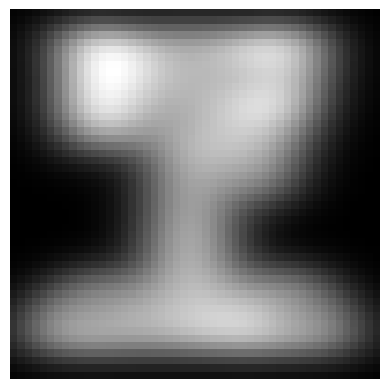

In [40]:
# This line applies the blurring operator (Cop) to the original image (im)
# using the convolution operation.
imblur = Cop * im

#----------------------------------------
print(type(imblur))
print(imblur.shape)

# Hiển thị hình ảnh gốc
plt.imshow(im, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()
# Hiển thị hình ảnh đã làm mờ
plt.imshow(imblur, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()


Tạo W chứa cơ sở wavelet

In [41]:
# Wavelet Transform:
# Initializes a 2D discrete wavelet transform operator (Wop)
# using the Haar wavelet.
Wop = pylops.signalprocessing.DWT2D((hang, cot), wavelet="haar")
# Wop = pylops.signalprocessing.DWT2D((hang, cot), wavelet="haar", level=3)

print(type(Wop))
print(Wop.shape)


<class 'pylops.signalprocessing.dwt2d.DWT2D'>
(4096, 2500)


Khử mờ sử dụng thuật toán FISTA có sẵn trong thư viện pylops

<class 'numpy.ndarray'>
(4096,)
<class 'numpy.ndarray'>
(50, 50)


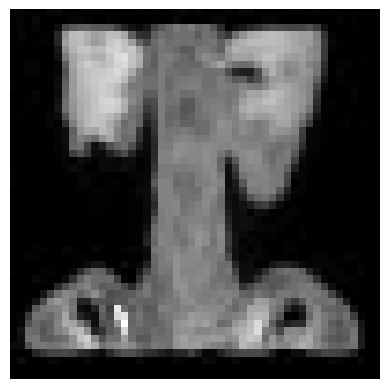

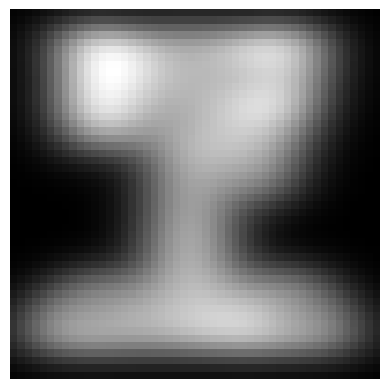

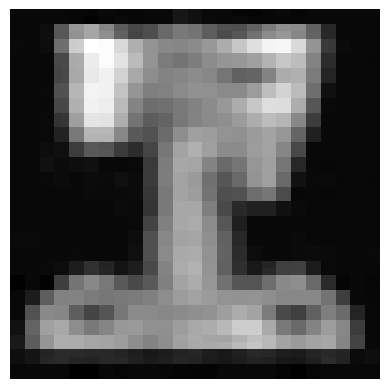

In [ ]:
# # This block performs TV deblurring using the FISTA algorithm.
# imdeblurfista = pylops.optimization.sparsity.fista(
#     Cop * Wop.H, imblur.ravel(), eps=1e-1, niter=100
# )[0]

# print(type(imdeblurfista))
# print(imdeblurfista.shape)

# imdeblurfista = imdeblurfista.reshape((Cop * Wop.H).dims)
# imdeblurfista = Wop.H * imdeblurfista # chuyển  hình ảnh về không gian màu gốc

# print(type(imdeblurfista))
# print(imdeblurfista.shape)
# # Hiển thị hình ảnh gốc
# plt.imshow(im, cmap='gray')
# plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
# plt.show()
# # Hiển thị hình ảnh đã làm mờ
# plt.imshow(imblur, cmap='gray')
# plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
# plt.show()
# # Hiển thị hình ảnh đã được khử mờ
# plt.imshow(imdeblurfista, cmap='gray')
# plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
# plt.show()

## Khử mờ sử dụng 3 thuật toán GAPGA1, GAPGA2, FISTA

In [42]:
print(type(Cop))
print(Cop.shape)

print(type(Wop))
print(Wop.shape)

print(type(Cop * Wop.H))
print((Cop * Wop.H).shape)

print(type(im))
print(im.shape)

# imblur = imblur.reshape((-1, 1))
print(type(imblur))
print(imblur.shape)


<class 'pylops.signalprocessing.convolve2d.Convolve2D'>
(2500, 2500)
<class 'pylops.signalprocessing.dwt2d.DWT2D'>
(4096, 2500)
<class 'pylops.linearoperator._ProductLinearOperator'>
(2500, 4096)
<class 'numpy.ndarray'>
(50, 50)
<class 'numpy.ndarray'>
(50, 50)


In [ ]:
# # imblur = imblur.ravel()
# imblur = imblur.reshape((-1, 1))
# print(type(imblur))
# print(imblur.shape)

<class 'numpy.ndarray'>
(47560, 1)


Chuyển Cop * Wop.H về <class 'numpy.ndarray'>

In [43]:
# A = Cop * Wop.H
A = Cop
A = A.matmat(np.identity(A.shape[1], dtype=np.float32))
print(type(A))

<class 'numpy.ndarray'>


In [44]:
print(type(imblur))
print(imblur.shape)

print(type(imblur.ravel()))
print(imblur.ravel().shape)


<class 'numpy.ndarray'>
(50, 50)
<class 'numpy.ndarray'>
(2500,)


In [45]:
print(type(A))
print(A.shape)

b = imblur.ravel() # xếp chồng các cột của ma trận imblur lại với nhau
b = b.reshape((-1, 1)) # đưa b về dạng ma trận m dòng, 1 cột

print(type(b))
print(b.shape)

<class 'numpy.ndarray'>
(2500, 2500)
<class 'numpy.ndarray'>
(2500, 1)


In [46]:
tic = time.time()
FISTA_results = FISTA(A, b, max_iter)
toc = time.time()

FISTA_time = toc - tic

In [47]:
tic = time.time()
GAPGA1_results = GAPGA1(A ,b, max_iter, modified = False)
toc = time.time()

GAPGA1_time = toc - tic

In [48]:
tic = time.time()
GAPGA2_results = GAPGA2(A ,b, max_iter, modified = False)
toc = time.time()

GAPGA2_time = toc - tic

## Hiện thị kết quả của thuật toán FISTA

In [58]:
# Truy cập thông tin từ kết quả FISTA
k_final = FISTA_results['k']  # Số lần lặp cuối cùng
x_final = FISTA_results['x'][-1]  # Véc-tơ tối ưu cuối cùng
F_final = FISTA_results['F'][-1]  # Giá trị của hàm mất mát tối ưu cuối cùng

# In thông tin
print(f"Số lần lặp cuối cùng: {k_final}")
print(f"Véc-tơ tối ưu cuối cùng:\n{x_final}")
print(f"Giá trị của hàm mất mát tối ưu cuối cùng: {F_final}")


Số lần lặp cuối cùng: 500
Véc-tơ tối ưu cuối cùng:
[[-1.34997637+0.j]
 [-2.99318388+0.j]
 [-4.53482116+0.j]
 ...
 [-6.43460897+0.j]
 [-6.72339046+0.j]
 [-6.82953569+0.j]]
Giá trị của hàm mất mát tối ưu cuối cùng: 157.7914941331625


In [59]:
print(type(x_final))
print(x_final.shape)

<class 'numpy.ndarray'>
(2500, 1)


In [60]:
# Sử dụng reshape để chuyển về shape (50, 50)
imdeblur_final = x_final.reshape((hang, cot))

# Kiểm tra shape của imblur_final
print(imdeblur_final.shape)


(50, 50)


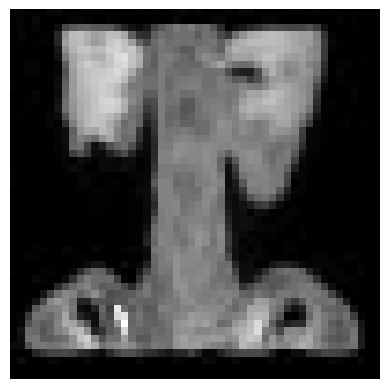

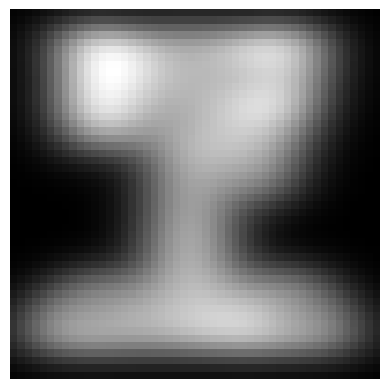

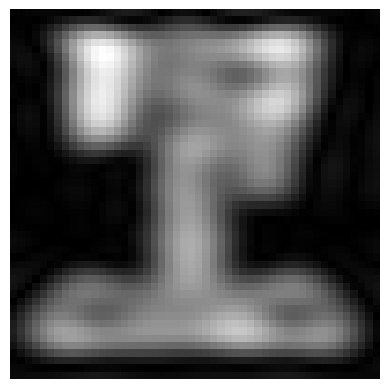

In [66]:
# Hiển thị hình ảnh gốc
plt.imshow(im, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()

# Hiển thị hình ảnh đã làm mờ
plt.imshow(imblur, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()

# # Hiển thị hình ảnh đã được khử mờ
# plt.imshow(imdeblur_final, cmap='gray')
# plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
# plt.show()

# # Chọn hiển thị phần thực của ma trận phức tạp
# plt.imshow(np.real(imdeblur_final), cmap='gray')
# plt.axis('off')
# plt.show()

# Chuyển đổi ma trận phức tạp thành dạng dữ liệu float trước khi hiển thị
plt.imshow(np.abs(imdeblur_final), cmap='gray')
plt.axis('off')
plt.show()


## Hiện thị kết quả của thuật toán GAPGA 1

In [68]:
# Truy cập thông tin từ kết quả FISTA
k_final = GAPGA1_results['k']  # Số lần lặp cuối cùng
x_final = GAPGA1_results['x'][-1]  # Véc-tơ tối ưu cuối cùng
F_final = GAPGA1_results['F'][-1]  # Giá trị của hàm mất mát tối ưu cuối cùng

In [69]:
print(type(x_final))
print(x_final.shape)

<class 'numpy.ndarray'>
(2500, 1)


In [70]:
# Sử dụng reshape để chuyển về shape (50, 50)
imdeblur_final = x_final.reshape((hang, cot))

# Kiểm tra shape của imdeblur_final
print(imdeblur_final.shape)

(50, 50)


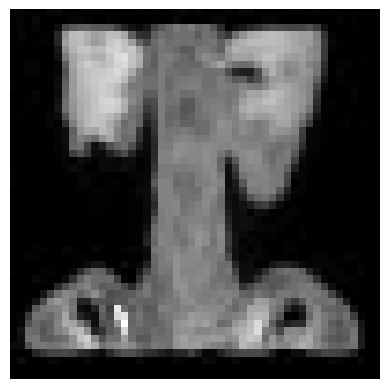

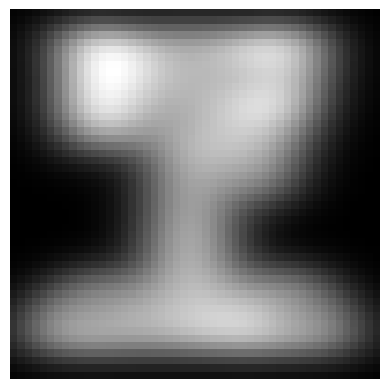

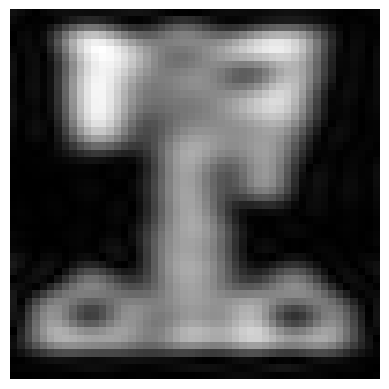

In [71]:
# Hiển thị hình ảnh gốc
plt.imshow(im, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()

# Hiển thị hình ảnh đã làm mờ
plt.imshow(imblur, cmap='gray')
plt.axis('off')  # Tắt trục để không hiển thị các chỉ số trục
plt.show()

# Chuyển đổi ma trận phức tạp thành dạng dữ liệu float trước khi hiển thị
plt.imshow(np.abs(imdeblur_final), cmap='gray')
plt.axis('off')
plt.show()


___RESULT____
m = 2500, n = 2500
FISTA:
 time = 125.3601565361023,
 F = 157.7914941331625,
 num iter = 500
GAPGA1:
 time = 169.0742666721344,
 F = 3.750352245937552,
 num iter = 500
GAPGA2:
 time = 173.55159425735474,
 F = 7.71965699095144e+228,
 num iter = 500


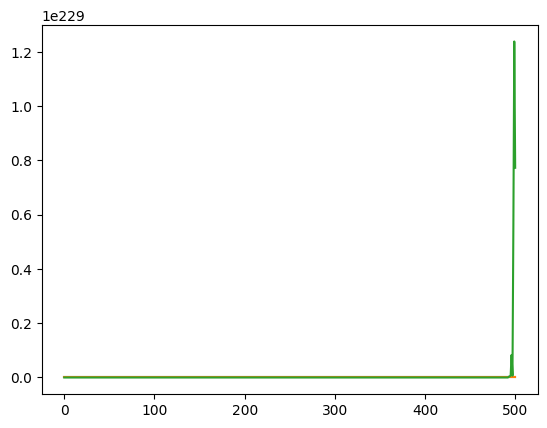

In [67]:
# %%capture cap --no-stderr
print('___RESULT____')
print(f"m = {m}, n = {n}")

#print(f"ISTA:\n time ={ISTA_time},\n F = {ISTA_results['F'][-1]},\n num iter = {ISTA_results['k']}")
print(f"FISTA:\n time = {FISTA_time},\n F = {FISTA_results['F'][-1]},\n num iter = {FISTA_results['k']}")
print(f"GAPGA1:\n time = {GAPGA1_time},\n F = {GAPGA1_results['F'][-1]},\n num iter = {GAPGA1_results['k']}")
print(f"GAPGA2:\n time = {GAPGA2_time},\n F = {GAPGA2_results['F'][-1]},\n num iter = {GAPGA2_results['k']}")
# print(f"GAFBA c1 = {c1}, c2 = {c2}:\n time ={GAFBA_time},\n F = {GAFBA_results['F'][-1]},\n num iter = {GAFBA_results['k']}")

#plt.plot(ISTA_results['F'][:],label = 'ISTA')
plt.plot(FISTA_results['F'][:],label = 'FISTA')
plt.plot(GAPGA1_results['F'][:],label = 'GAPGA1') # 300 là số vòng lặp muốn xem
plt.plot(GAPGA2_results['F'][:],label = 'GAPGA2')
# plt.plot(GAFBA_results['F'][:], label = 'GAFBA') # 300 là số vòng lặp muốn xem
# plt.legend()
# plt.savefig(f'fig_{file_name}')
# plt.show()

try:
    print(data.DESCR)
except:
    pass

# Không cần dòng này nếu bạn không sử dụng %%capture
# with open(f'{file_name}.txt', 'w') as f:
    # f.write(cap.stdout)

In kết quả

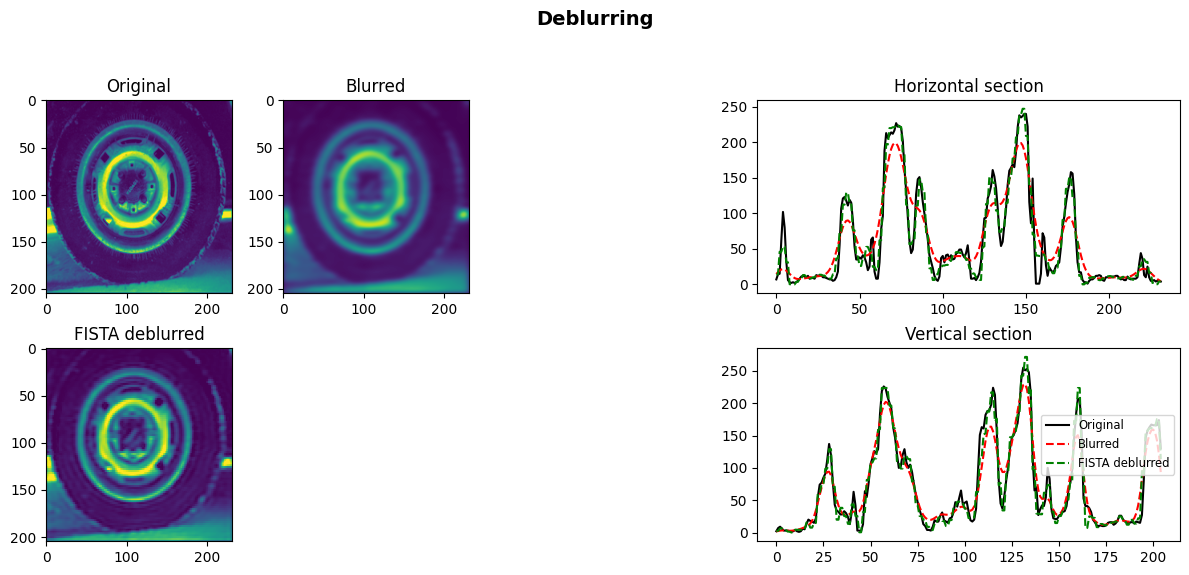

In [ ]:
# # sphinx_gallery_thumbnail_number = 2
# fig = plt.figure(figsize=(12, 6))
# fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95)
# ax1 = plt.subplot2grid((2, 5), (0, 0))
# ax2 = plt.subplot2grid((2, 5), (0, 1))
# # ax3 = plt.subplot2grid((2, 5), (0, 2))
# ax4 = plt.subplot2grid((2, 5), (1, 0))
# # ax5 = plt.subplot2grid((2, 5), (1, 1))
# # ax6 = plt.subplot2grid((2, 5), (1, 2))
# ax7 = plt.subplot2grid((2, 5), (0, 3), colspan=2)
# ax8 = plt.subplot2grid((2, 5), (1, 3), colspan=2)
# ax1.imshow(im, cmap="viridis", vmin=0, vmax=250)
# ax1.axis("tight")
# ax1.set_title("Original")
# ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
# ax2.axis("tight")
# ax2.set_title("Blurred")
# # ax3.imshow(imdeblur, cmap="viridis", vmin=0, vmax=250)
# # ax3.axis("tight")
# # ax3.set_title("Deblurred")
# ax4.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
# ax4.axis("tight")
# ax4.set_title("FISTA deblurred")
# # ax5.imshow(imdeblurtv, cmap="viridis", vmin=0, vmax=250)
# # ax5.axis("tight")
# # ax5.set_title("TV deblurred")
# # ax6.imshow(imdeblurtv1, cmap="viridis", vmin=0, vmax=250)
# # ax6.axis("tight")
# # ax6.set_title("TV+Haar deblurred")
# ax7.plot(im[Nz // 2], "k")
# ax7.plot(imblur[Nz // 2], "--r")
# # ax7.plot(imdeblur[Nz // 2], "--b")
# ax7.plot(imdeblurfista[Nz // 2], "--g")
# # ax7.plot(imdeblurtv[Nz // 2], "--m")
# # ax7.plot(imdeblurtv1[Nz // 2], "--y")
# ax7.axis("tight")
# ax7.set_title("Horizontal section")
# ax8.plot(im[:, Nx // 2], "k", label="Original")
# ax8.plot(imblur[:, Nx // 2], "--r", label="Blurred")
# # ax8.plot(imdeblur[:, Nx // 2], "--b", label="Deblurred")
# ax8.plot(imdeblurfista[:, Nx // 2], "--g", label="FISTA deblurred")
# # ax8.plot(imdeblurtv[:, Nx // 2], "--m", label="TV deblurred")
# # ax8.plot(imdeblurtv1[:, Nx // 2], "--y", label="TV+Haar deblurred")
# ax8.axis("tight")
# ax8.set_title("Vertical section")
# ax8.legend(loc=5, fontsize="small")
# plt.tight_layout()
# plt.subplots_adjust(top=0.8)

## Bài toán phân cụm dữ liệu

In [ ]:
# # data = datasets.load_boston()  # load_boston, load_breast_cancer, load_diabetes, load_digits, load_iris, load_wine()
# # data = sklearn.datasets.load_boston()   ##fetch_california_housing(), fetch_olivetti_faces(), fetch_covtype(),
#                                   ## fetch_kddcup99(),
#                                   ## fetch_covtype(), fetch_lfw_people(), fetch_lfw_pairs(), fetch_rcv1(),
# # data = fetch_openml(data_id=531)
# # file_name = 'Boston-house-price-data'

# file_name = 'blood-transfusion-service-center'
# data = fetch_openml(file_name) # Tên các bộ dữ liệu lấy ở https://www.openml.org/search?type=data

# A = data['data']
# # print(type(A)) #DataFrame

# A = A.to_numpy(dtype=np.float64) #flag
# # print(type(A[0][0])) #float64

# b = data['target']
# # print(type(b[0])) #string/float/int/bool/...

# b = b[:, np.newaxis] #chuyển vị
# # print(b)

# m = A.shape[0] # so hang
# n = A.shape[1]# so cot



/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-15-f0b110fd773c>:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  b = b[:, np.newaxis] #chuyển vị


In [ ]:
# m_b = b.shape[0] # so hang
# n_b = b.shape[1] # so cot
# print(f"m = {m}, n = {n}")
# print(f"m_b = {m_b}, n_b = {n_b}")

m = 748, n = 4
m_b = 748, n_b = 1


In [ ]:
# A.head() #trước khi run phải comment đoạn code A = A.to_numpy(dtype=np.float64) lại

In [ ]:
## Nếu sinh dữ liệu random thì uncomment cell ở dưới ( select all rồi gõ "CTRL + /" ), điều chỉnh m, n mong muốn

In [ ]:
# m = 500
# n = 1000

# A = rnd.rand(m,n)
# b = rnd.rand(m,1)

In [ ]:
# _lambda = 10**-6
# max_iter = 500
# epsilon = 10**-3

Đổi dữ liệu về dạng số

Dữ liệu có thể đang ko phải ở dạng số( true/false positive/negative '0'/'1'), cần chuyển nó về dạng số trước.
Chỉnh sửa cell bên dưới về để sửa b lại cho phù hợp

In [ ]:
# b = np.where(b=='0',0.0,b) # Thay đổi string `0` thành 0
# b = np.where(b=='2',2.0,b) # Thay đổi string `2` thành 2
# b = np.where(b=='1',1.0,b) # Thay đổi string `1` thành 1
# b = np.where(b=='negative',0.0,b)
# b = np.where(b=='positive',1,b)
# b = np.where(b=='false',0.0,b)
# b = np.where(b=='true',1,b)
# b = np.where(b=='good',1,b)
# b = np.where(b=='bad',0,b)
# b = np.array(b,dtype = float)

In [ ]:
# tic = time.time()
# FISTA_results = FISTA(A ,b, max_iter)
# toc = time.time()

# FISTA_time = toc - tic

In [ ]:
# tic = time.time()
# GAPGA1_results = GAPGA1(A ,b, max_iter, modified = False)
# toc = time.time()

# GAPGA1_time = toc - tic

In [ ]:
# tic = time.time()
# GAPGA2_results = GAPGA2(A ,b, max_iter, modified = False)
# toc = time.time()

# GAPGA2_time = toc - tic

___RESULT____
m = 748, n = 4
FISTA:
 time = 0.06565737724304199,
 F = 228.06470040326832,
 num iter = 500
GAPGA1:
 time = 0.0015535354614257812,
 F = 325.74663080702743,
 num iter = 1
GAPGA2:
 time = 0.0010981559753417969,
 F = 325.74663080702743,
 num iter = 1


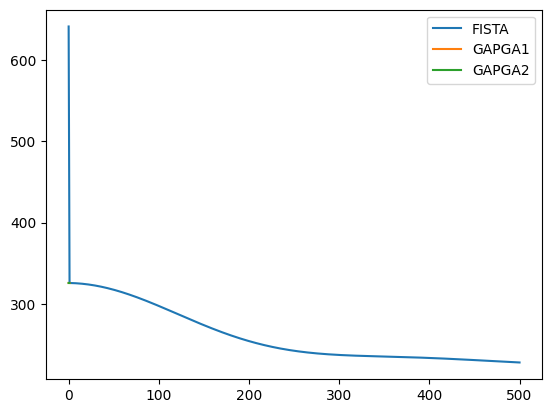

**Author**: Prof. I-Cheng Yeh  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center)  
**Please cite**: Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence", Expert Systems with Applications, 2008.   

**Blood Transfusion Service Center Data Set**  
Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan -- this is a classification problem.

To demonstrate the RFMTC marketing model (a modified version of RFM), this study adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. To build an FRMTC model, we selected 748 donors at random from the donor database. 

### Attribute Information  
* V1: Recency - months since last donation
* V2: Frequency - total number of donation
* V3: Monetary - total bl

In [ ]:
# # %%capture cap --no-stderr
# print('___RESULT____')
# print(f"m = {m}, n = {n}")

# #print(f"ISTA:\n time ={ISTA_time},\n F = {ISTA_results['F'][-1]},\n num iter = {ISTA_results['k']}")
# print(f"FISTA:\n time = {FISTA_time},\n F = {FISTA_results['F'][-1]},\n num iter = {FISTA_results['k']}")
# print(f"GAPGA1:\n time = {GAPGA1_time},\n F = {GAPGA1_results['F'][-1]},\n num iter = {GAPGA1_results['k']}")
# print(f"GAPGA2:\n time = {GAPGA2_time},\n F = {GAPGA2_results['F'][-1]},\n num iter = {GAPGA2_results['k']}")
# # print(f"GAFBA c1 = {c1}, c2 = {c2}:\n time ={GAFBA_time},\n F = {GAFBA_results['F'][-1]},\n num iter = {GAFBA_results['k']}")

# #plt.plot(ISTA_results['F'][:],label = 'ISTA')
# plt.plot(FISTA_results['F'][:],label = 'FISTA')
# plt.plot(GAPGA1_results['F'][:],label = 'GAPGA1') # 300 là số vòng lặp muốn xem
# plt.plot(GAPGA2_results['F'][:],label = 'GAPGA2')
# # plt.plot(GAFBA_results['F'][:], label = 'GAFBA') # 300 là số vòng lặp muốn xem
# plt.legend()
# plt.savefig(f'fig_{file_name}')
# plt.show()

# try:
#     print(data.DESCR)
# except:
#     pass

# # Không cần dòng này nếu bạn không sử dụng %%capture
# # with open(f'{file_name}.txt', 'w') as f:
#     # f.write(cap.stdout)

# Add nise to image

In [ ]:
# from skimage import data, io, filters

# def noisy(noise_typ,image):
#     if noise_typ == "gauss":
#         row,col,ch= image.shape
#         mean = 0
#         var = 0.1
#         sigma = var**0.5
#         gauss = np.random.normal(mean,sigma,(row,col,ch))
#         gauss = gauss.reshape(row,col,ch)
#         noisy = image + gauss
#         return noisy
#     elif noise_typ == "s&p":
#         row,col,ch = image.shape
#         s_vs_p = 0.5
#         amount = 0.004
#         out = np.copy(image)
#         # Salt mode
#         num_salt = np.ceil(amount * image.size * s_vs_p)
#         coords = [np.random.randint(0, i - 1, int(num_salt))
#               for i in image.shape]
#         out[coords] = 1

#         # Pepper mode
#         num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#         coords = [np.random.randint(0, i - 1, int(num_pepper))
#               for i in image.shape]
#         out[coords] = 0
#         return out
#     elif noise_typ == "poisson":
#         vals = len(np.unique(image))
#         vals = 2 ** np.ceil(np.log2(vals))
#         noisy = np.random.poisson(image * vals) / float(vals)
#         return noisy
#     elif noise_typ =="speckle":
#         row,col,ch = image.shape
#         gauss = np.random.randn(row,col,ch)
#         gauss = gauss.reshape(row,col,ch)
#         noisy = image + image * gauss
#         return noisy

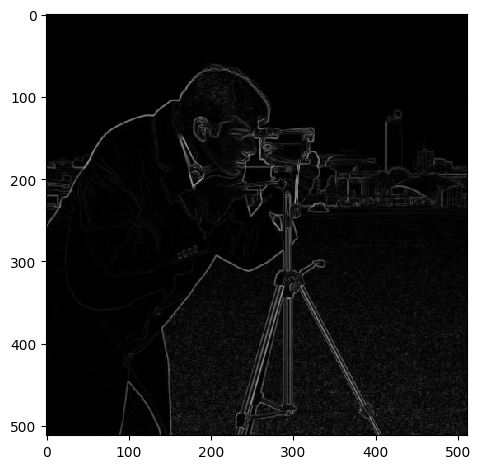

In [ ]:
# image = data.camera()
# edges = filters.sobel(image)
# io.imshow(edges)
# io.show()

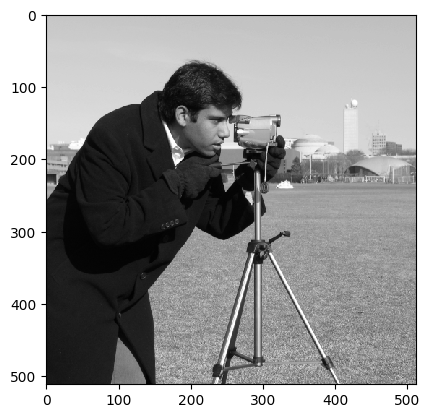

In [ ]:
# import matplotlib.pyplot as plt
# from skimage import data

# # Đọc hình ảnh từ thư viện skimage
# image = data.camera()

# # Hiển thị hình ảnh
# plt.imshow(image, interpolation='nearest')
# plt.gray()
# plt.show()

# # plt.imshow(data, interpolation='nearest')
# # plt.gray()
# # plt.show


In [ ]:
# data = 0.3*np.ones( (512,512,3), dtype=np.uint8)
# data[256,256] = [255,0,0]

<function matplotlib.pyplot.show(close=None, block=None)>

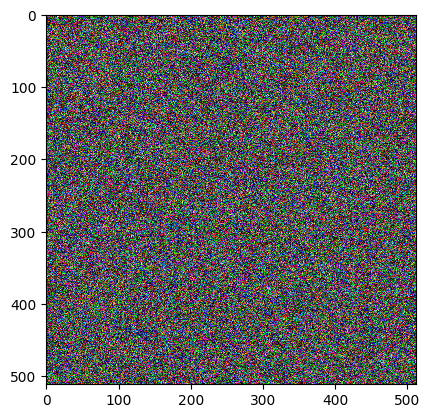

In [ ]:
# noised = noisy('gauss',data)
# plt.imshow(noised, interpolation='nearest')
# plt.show